## AIPI 590.01 Explainable AI

### Assignment 2: Interpretable ML

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nrutachoudhari/AIPI590.01_Explainable_AI_Assignments/blob/main/HW2_Interpretable_ML/AIPI%20590.01%20Assignment%202.ipynb)


In [51]:
# importing all the necessary libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

!pip install pygam
from pygam import LogisticGAM, s, f

In [2]:
# loading the main CSV
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1759,2243-FNMMI,Male,0,No,No,20,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.40,415.4,No
956,3261-CQXOL,Female,0,Yes,Yes,71,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.45,1813.35,No
6600,4592-IWTJI,Female,0,Yes,Yes,3,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Credit card (automatic),29.70,91.7,Yes
4328,1101-SSWAG,Female,0,Yes,No,15,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,51.10,711.15,No
3973,3441-CGZJH,Female,0,Yes,Yes,43,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),60.40,2640.55,No
1017,9361-YNQWJ,Female,0,No,No,64,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),24.40,1601.2,No
4936,3898-GUYTS,Female,1,No,No,45,Yes,Yes,Fiber optic,Yes,...,No,Yes,Yes,No,Month-to-month,Yes,Electronic check,97.05,4385.05,No
5140,7577-SWIFR,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,89.25,89.25,No
2922,3348-CFRNX,Female,0,Yes,No,28,Yes,No,Fiber optic,Yes,...,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,92.35,2602.9,Yes
4468,7083-YNSKY,Female,0,No,No,15,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),25.40,399.6,Yes


### **Task 1: Exploratory Data Analysis to check Assumptions**

Before jumping into the EDA section, listing out the assumptions of the three types of models.

#### **1. Linear Regression**
a. Linearity: There exists a linear relationship between the independent variable *x* and the dependent variable *y*

b. Independence of Errors: The residuals are independent. In particular, there is no correlation between consecutive residuals in the time series data

c. Normality of Errors: The residuals in the model are normally distributed

d. Equal Variance of Errors: The errors are homoscedastic or have equal variance at all levels.

#### **2. Logistic Regression**
a. The response variable is binary: Logistic regression assumes that the response variable only takes on one of two values.

b. The observations are independent: The observations must be independent of each other.

c. No Multicollinearity: The predictor variables should not be highly correlated to each other.

d. Linearity of Log-Odds: The predictors should have a linear relationship with the logit of the outcome.

e. The sample size is sufficiently large: Logistic regression works best with enough cases in both outcome categories.

#### **3. General Additive Model (GAM)**
a. Linearity in the Link Function: The relationship between the linear predictor and the expected value of the response (as determined by the link function) should be correctly specified.

b. Additivity: The effects of each predictor are additive. Each predictor contributes through a separate smooth function, and the sum of these smooth functions forms the overall prediction.

c. Smoothness: The smooth functions modeling predictor-response relationships should be continuous and gradually changing, avoiding abrupt jumps.

d. Independence of Observations: Each observation is independent, allowing standard inference. If data are clustered, a GAMM may be needed.

e. Distributional Assumptions: The response variable should follow a distribution from the exponential family (e.g., binomial for churn, Poisson for counts).

f. Absence of Multicollinearity: Predictor variables should not be highly correlated, to avoid unstable estimates and misinterpretation.

In [3]:
# quick overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


> ```TotalCharges``` is listed as an object when it has float values. ```SeniorCitizen``` is an integer column taking 0 and 1 values and should be converted to a categorical variable.
> All the columns do not have any null values.

In [4]:
# convering TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# converting senior citizen to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# defining a Churn_num which makes it easier for plotting
df['Churn_num'] = df['Churn'].map({'No':0, 'Yes':1})

In [5]:
# checking if there are any NAs in the data after the transformations
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
Churn_num            0
dtype: int64

> There are 11 NA values in the `TotalCharges` column. Dropping those values.

In [ ]:
# dropping the NAs rows
df.dropna(inplace = True)

<Axes: title={'center': 'Churn distribution'}, xlabel='Churn'>

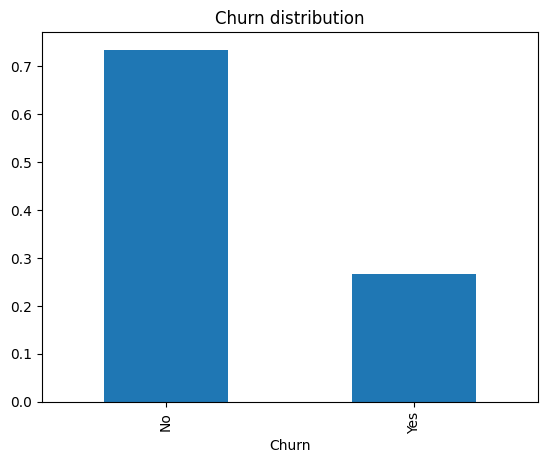

In [ ]:
# checking the distribution of the Churn
df['Churn'].value_counts(normalize= True).plot(kind='bar', title = 'Churn distribution')

> There is a clear imbalance between the distribution of the Churn variable. There is a higher proportion of data that is distributed as No

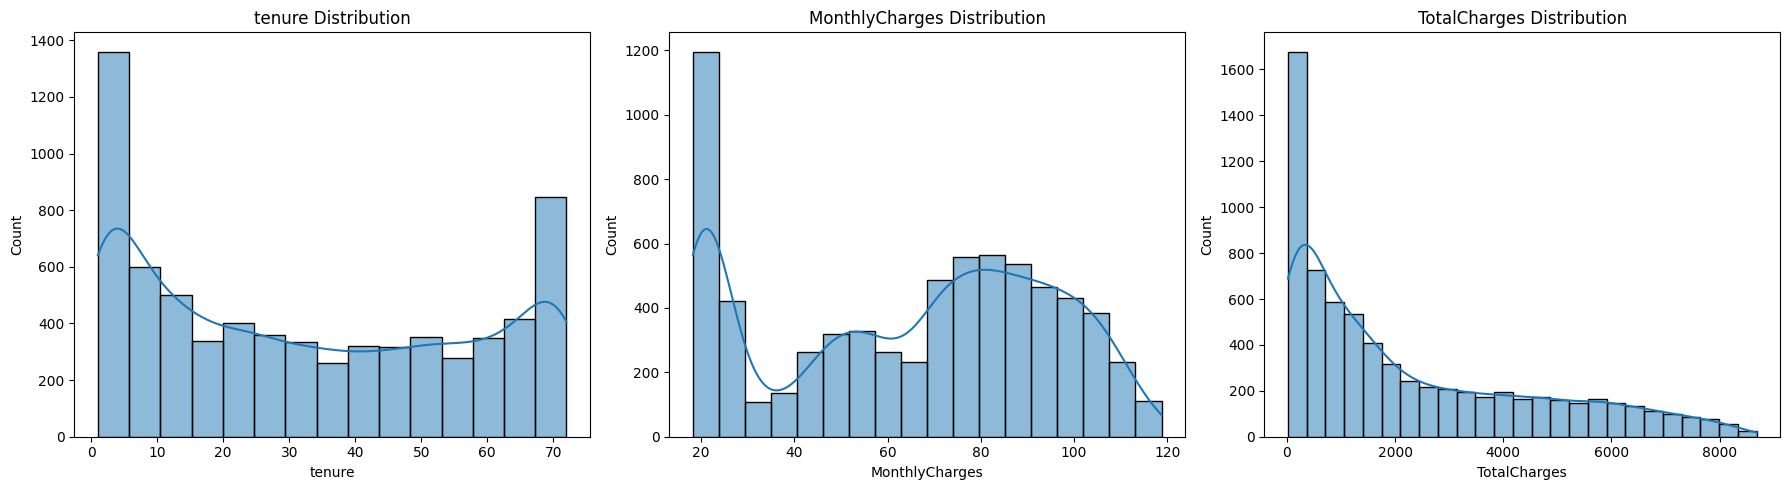

In [9]:
# checking the distribution of the numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()


> None of the numeric predictors follow a normal distribution which may motivate transformations or the use of GAMs that are more flexible with non-normal distributions

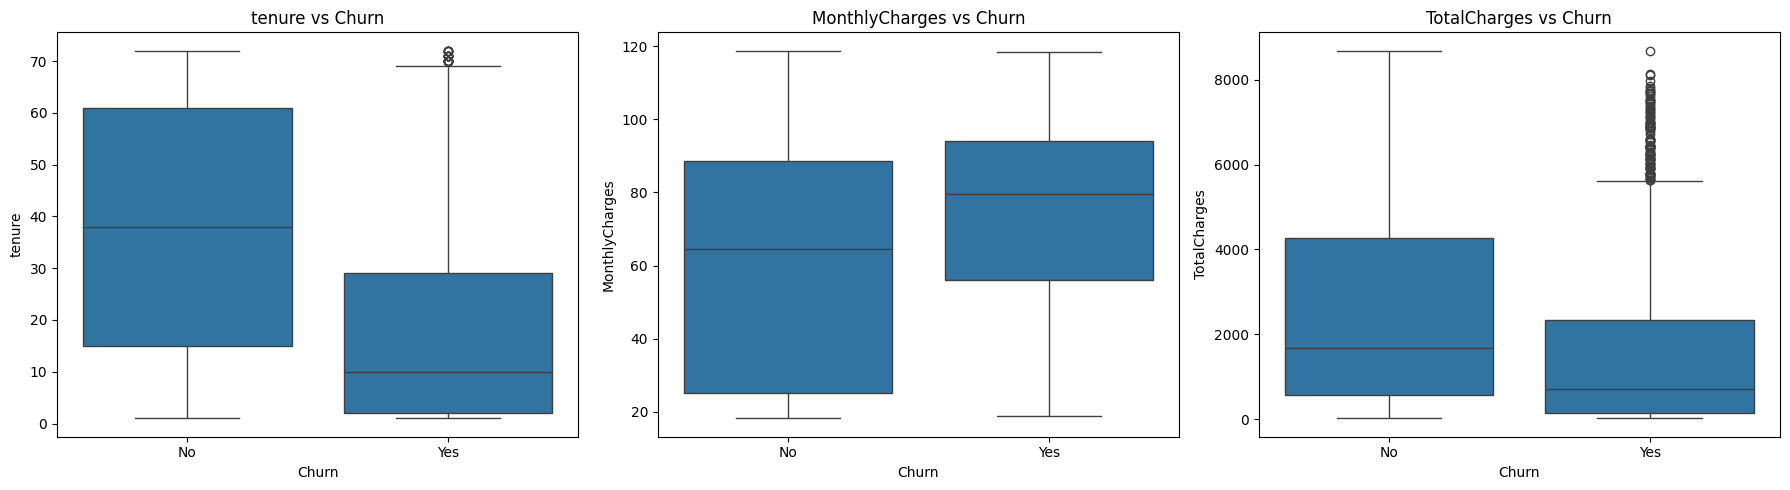

In [10]:
# checking the relationship of the numeric predictors with the target variable

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Churn')

plt.tight_layout()
plt.show()

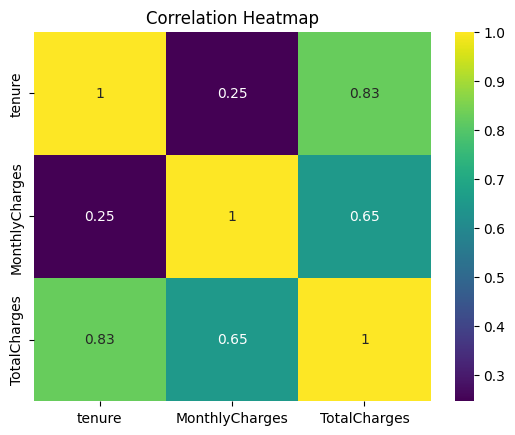

In [11]:
# creating a correlation heatmap to check for multicollinearity amongst the numerical columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()


> `MonthlyCharges` and `TotalCharges` are moderately correlated while `tenure` and `TotalCharges` are highly correlated.

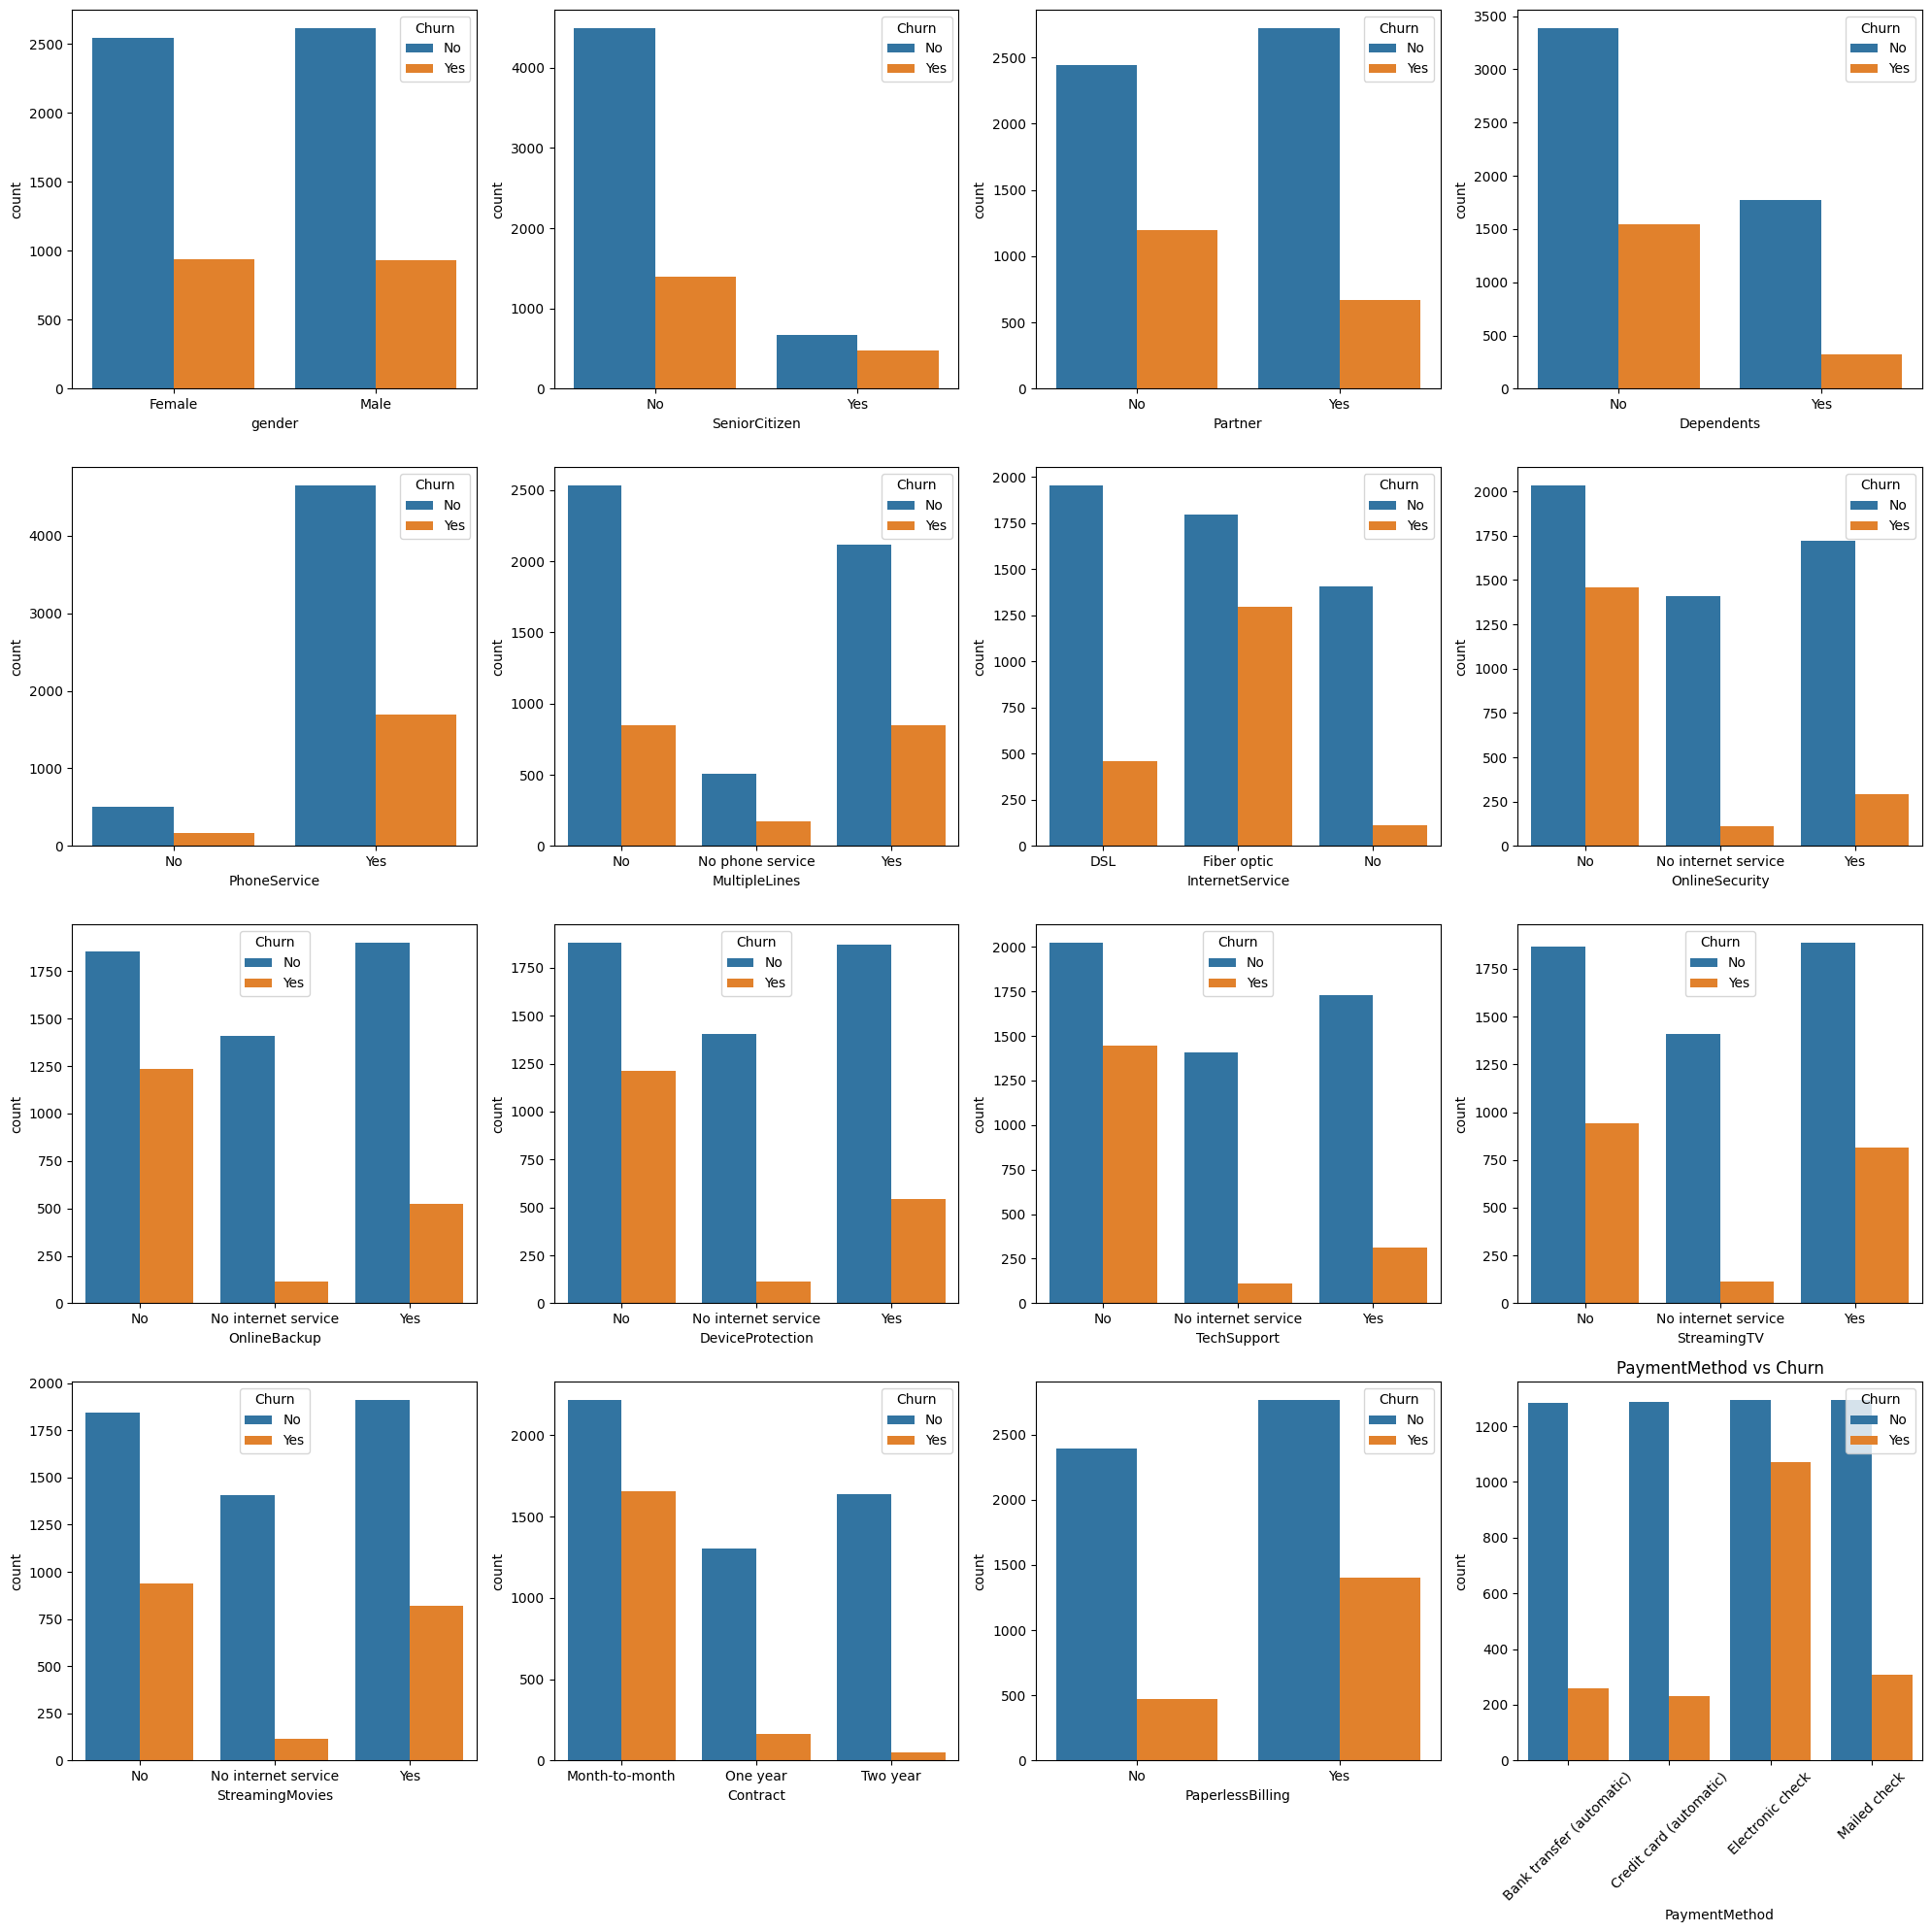

In [12]:
# defining the categorical variables and checking their distribution with respect to Churn
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

df[categorical_cols] = df[categorical_cols].astype("category")

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    plt.xticks(rotation=45)
    plt.title(f'{col} vs Churn')

plt.tight_layout()
plt.show()



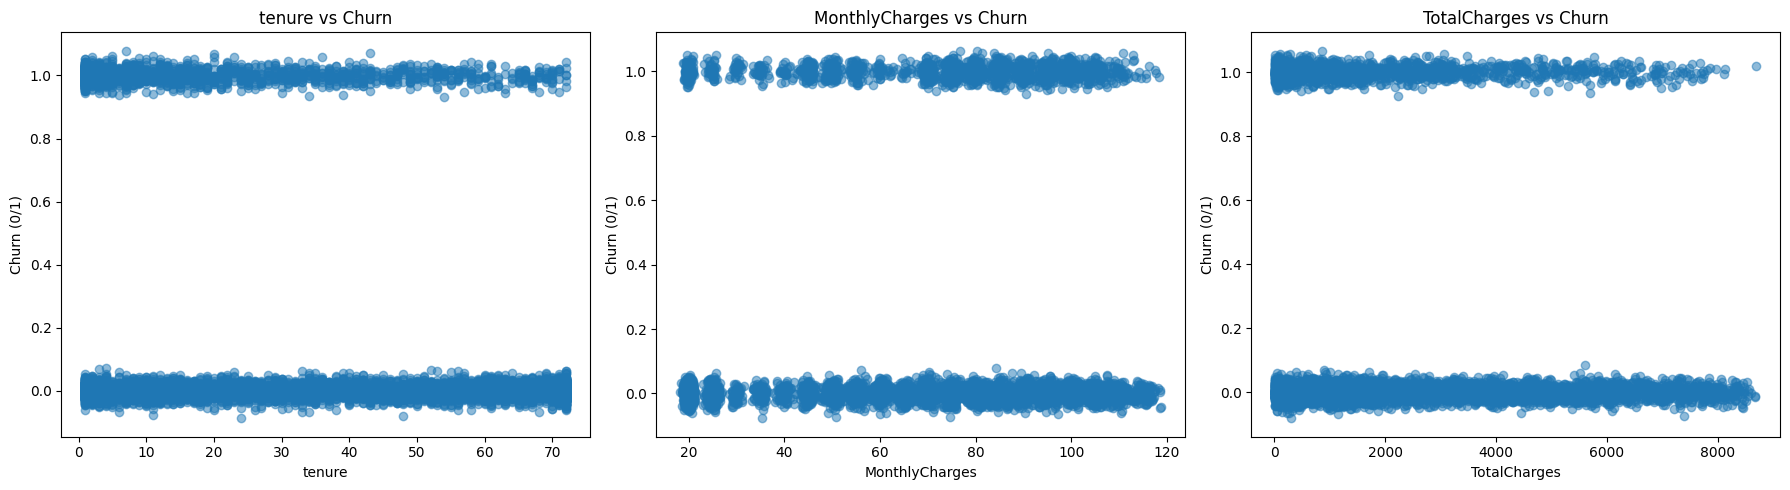

In [ ]:
# plotting scatter plots of churn against the numeric predictors to check for linear relationship
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_cols):
    y_jitter = df['Churn_num'] + np.random.normal(0, 0.02, size=len(df))
    axes[i].scatter(df[col], y_jitter, alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Churn (0/1)')
    axes[i].set_title(f'{col} vs Churn')

plt.tight_layout()
plt.show()

> The scatter plots reveal a non-linear relationship between Churn and tenure, MonthlyCharges and TotalCharges.

### **Task 2: Linear Regression**

In [14]:
# defining the X and y
y = df["Churn_num"]
X = df.drop(columns=["Churn", "Churn_num", "customerID"])

# converting the categorical variables to one hot encoding as linear regression need numerical inputs
X = pd.get_dummies(X, drop_first=True)
X = X.astype(int)

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# add constant for OLS
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# fit model
linear_model = sm.OLS(y_train, X_train_const).fit()

# summary
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Churn_num   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     87.35
Date:                Sun, 14 Sep 2025   Prob (F-statistic):               0.00
Time:                        11:34:14   Log-Likelihood:                -2116.6
No. Observations:                4922   AIC:                             4281.
Df Residuals:                    4898   BIC:                             4437.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

> The R-squared value is 0.291 which means that only 29.1% of the variance is explained by the model. This is too be expected, as churn is a binary outcome that is better suited for logistic models.
>
> The key coefficients can be interpreted as follows:
>
> * Tenure: Each additional month reduces churn probability by about 0.19%, holding other factors constant.
> * TotalCharges: Higher total charges are associated with a small but significant decrease in churn probability.
> * SeniorCitizen: Being a senior citizen increases churn probability by ~3.9%.
> * InternetService (Fiber optic): Customers with fiber optic service are significantly more likely to churn (~30% higher).
> * Contract type: One-year and two-year contracts significantly reduce churn probability, indicating contract length is a strong retention factor.
> * Payment method (Electronic check): Associated with a ~7.2% higher churn probability.
>
> Some predictors, such as MonthlyCharges and gender, are not statistically significant (p > 0.05), suggesting they don’t meaningfully affect churn once other variables are considered.
>
>The Omnibus and Jarque-Bera tests are significant, showing residuals are not normally distributed. This is expected when applying OLS to a binary outcome.
>
> The Durbin-Watson statistic is 2.004, very close to 2, indicating no strong autocorrelation in residuals.

In [ ]:
# predicting the churn probabilities
y_pred = linear_model.predict(X_test_const)

# clip values to [0,1] for illustration
y_pred_clipped = np.clip(y_pred, 0, 1)

# calculating the metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# simple accuracy using 0.5 threshold
y_pred_class = (y_pred >= 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_class)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, Accuracy: {acc:.4f}")

MSE: 0.1434, MAE: 0.3005, Accuracy: 0.7957


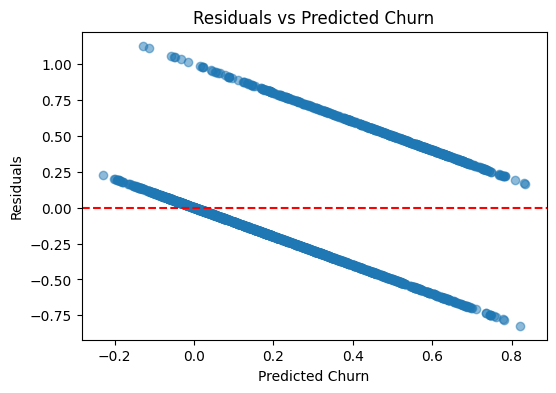

In [17]:
# calculating the residuals
residuals = y_test - y_pred

# residual plot
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Churn")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Churn")
plt.show()

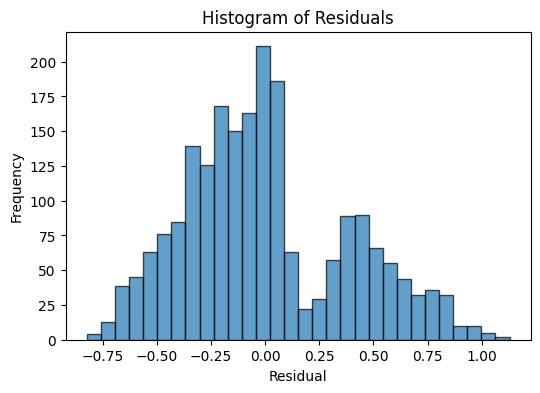

In [18]:
# histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

> MSE = 0.1434. On average, the squared error between predicted churn probability and actual 0/1 values is 0.1434.
>
> MAE = 0.3005 → on average, predicted probabilities are off by ~30 percentage points.
>
> Accuracy = 0.7957 → using a 0.5 cutoff, the model correctly classifies ~79.5% of customers.
>
> Even though the accuracy of the model is pretty decent, LPM can produce predicted probabilities outside [0,1] and doesn’t handle the binary nature perfectly.
>
> The residuals show two distinct bands and a clear pattern, indicating heteroskedasticity and non-normality, which is common in linear probability models. While the linear regression model gives a rough estimate of churn probabilities, logistic regression or GAMs provide more reliable probability predictions.

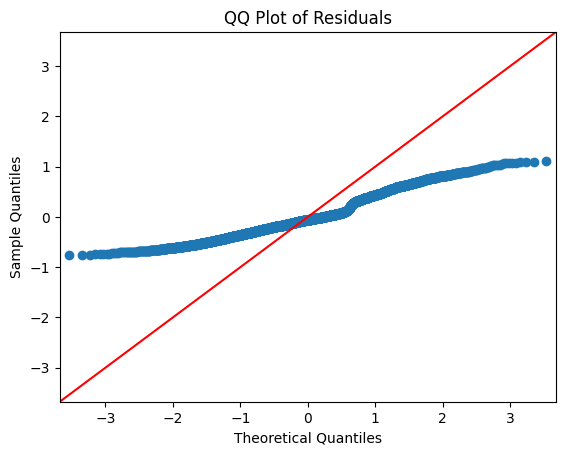

In [ ]:
# plotting the QQ plot to check for normality of residuals
residuals = linear_model.resid

sm.qqplot(residuals, line="45")

plt.title("QQ Plot of Residuals")
plt.show()

In [20]:
# checking VIF for multicollinearity
vif = pd.DataFrame()
vif['feature'] = X_train_const.columns
vif['VIF'] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
vif

,feature,VIF
0,const,0.000000
1,tenure,7.492636
2,MonthlyCharges,827.403016
3,TotalCharges,10.729185
4,gender_Male,1.004195
5,SeniorCitizen_Yes,1.151911
6,Partner_Yes,1.455510
7,Dependents_Yes,1.375090
8,PhoneService_Yes,inf
9,MultipleLines_No phone service,inf


> Further, with the QQ plot, we can see that the residuals are not normally distributed.
>
> The VIF table also shows severe multicollinearity amongst several of the variables.
>
> Many of the assumptions of linear regression are not met by this data.

##### Using Lasso for feature importance

In [ ]:
# standardizing the features for using lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# LassoCV automatically selects the best alpha
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

print(f"Optimal alpha: {lasso_cv.alpha_}")

Optimal alpha: 0.0020428513844178414


In [ ]:
# fitting the lasso model
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso MSE: {mse_lasso}")

y_pred_lasso_binary = [1 if i > 0.5 else 0 for i in y_pred_lasso]
print(f"Lasso Accuracy: {accuracy_score(y_test, y_pred_lasso_binary)}")

Lasso MSE: 0.14292213011824983
Lasso Accuracy: 0.7985781990521327


> We see that with the Lasso model, the accuracy increases by 0.03% and the MSE reduces by 0.0005.


In [ ]:
# creating a dataframe of coefficients
lasso_coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})

# keeping only non-zero coefficients
lasso_coefs = lasso_coefs[lasso_coefs['Coefficient'] != 0]
lasso_coefs['Abs_Coefficient'] = lasso_coefs['Coefficient'].abs()
lasso_coefs = lasso_coefs.sort_values(by='Abs_Coefficient', ascending=False)

print(lasso_coefs)

                                 Feature   Coefficient  Abs_Coefficient
2                           TotalCharges -8.708441e-02     8.708441e-02
10           InternetService_Fiber optic  8.503028e-02     8.503028e-02
0                                 tenure -5.322526e-02     5.322526e-02
11                    InternetService_No -4.583083e-02     4.583083e-02
24                     Contract_One year -4.148378e-02     4.148378e-02
28        PaymentMethod_Electronic check  3.277069e-02     3.277069e-02
25                     Contract_Two year -2.925038e-02     2.925038e-02
19                       TechSupport_Yes -2.739435e-02     2.739435e-02
9                      MultipleLines_Yes  2.615866e-02     2.615866e-02
13                    OnlineSecurity_Yes -2.516450e-02     2.516450e-02
23                   StreamingMovies_Yes  2.407282e-02     2.407282e-02
21                       StreamingTV_Yes  2.278200e-02     2.278200e-02
26                  PaperlessBilling_Yes  2.062524e-02     2.062

> With the lasso model, we can see that `TotalCharges`, `InternetService_Fiber optic` and `tenure` are the strongest churn predictors. Longer tenure reduces churn, while higher charges and fiber optic services increase it. Contract type also matters as one and two-year contracts lower the churn rate. Electronic check payments raise it. Service features like `TechSupport_Yes` and `OnlineSecurity_Yes` reduce churn, while `StreamingTV` and `StreamingMovies` slightly increase it.
>
> The features that have shrunk to near zero contribute little and can be safely dropped.

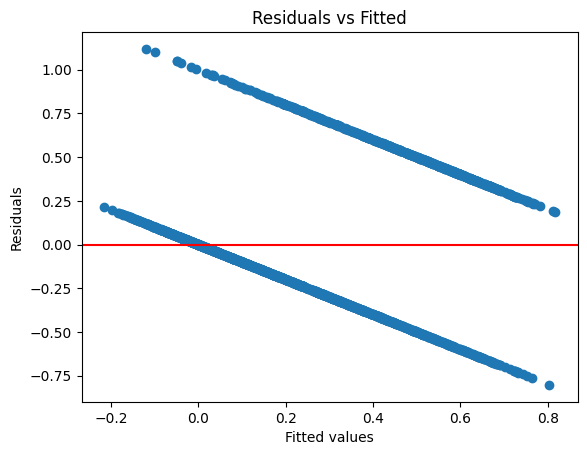

In [25]:
fitted = lasso_cv.predict(X_test_scaled)
residuals = y_test - fitted

plt.scatter(fitted, residuals)
plt.axhline(y=0, color="red", label="0")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

<Figure size 1000x600 with 0 Axes>

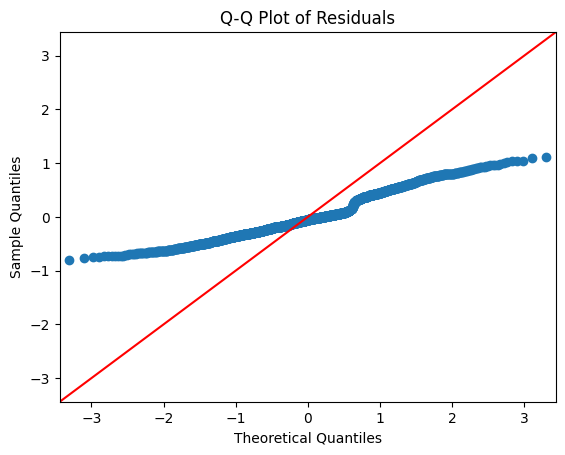

In [26]:
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line="45")
plt.title("Q-Q Plot of Residuals")
plt.show()

> From the residual plot and the QQ plot, we see that these assumptions are still being violated.

> Keeping these features only for logistic and GAM for simplicity.

### **Task 3: Logistic Regression**

In [ ]:
# selecting only the features selected by lasso for logistic regression and GAM
X_train_sel = X_train[lasso_coefs['Feature']]
X_test_sel = X_test[lasso_coefs['Feature']]

In [ ]:
# dropping the constant columns
nunique = X_train_sel.nunique()
const_cols = nunique[nunique <= 1].index.tolist()
if const_cols:
    print("Dropping constant columns:", const_cols)
    X_train_sel = X_train_sel.drop(columns=const_cols)
    X_test_sel = X_test_sel.drop(columns=const_cols)

In [30]:
# we need to add constant
X_vif = sm.add_constant(X_train_sel)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data)

                                 feature        VIF
0                                  const   0.000000
1                           TotalCharges  10.137118
2            InternetService_Fiber optic   2.362276
3                                 tenure   6.964689
4                     InternetService_No        inf
5                      Contract_One year   1.612136
6         PaymentMethod_Electronic check   1.314783
7                      Contract_Two year   2.623112
8                        TechSupport_Yes   1.514383
9                      MultipleLines_Yes   1.446895
10                    OnlineSecurity_Yes   1.463795
11                   StreamingMovies_Yes   1.720087
12                       StreamingTV_Yes   1.725396
13                  PaperlessBilling_Yes   1.201575
14                        Dependents_Yes   1.112918
15                     SeniorCitizen_Yes   1.139635
16                      OnlineBackup_Yes   1.454962
17       StreamingTV_No internet service        inf
18          

> Several features, such as `InternetService_No` and `PhoneService_Yes`, have infinite VIF values, suggesting perfect multicollinearity. It would be ideal to drop or combine these variables to avoid instability in regression models.

In [ ]:
# making a list of columns to drop based on high VIF
drop_cols = [
    'InternetService_No',
    'StreamingTV_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'OnlineSecurity_No internet service',
    'TechSupport_No internet service',
    'PhoneService_Yes',
    'MultipleLines_No phone service'
]

# dropping the columns from train and test set
X_train_sel = X_train_sel.drop(columns=drop_cols, errors='ignore')
X_test_sel  = X_test_sel.drop(columns=drop_cols, errors='ignore')

In [ ]:
# checking VIF again after dropping the columns
X_vif = sm.add_constant(X_train_sel)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data)

                           feature       VIF
0                            const  7.804322
1                     TotalCharges  9.559819
2      InternetService_Fiber optic  2.148664
3                           tenure  6.551587
4                Contract_One year  1.557054
5   PaymentMethod_Electronic check  1.285332
6                Contract_Two year  2.438611
7                  TechSupport_Yes  1.412028
8                MultipleLines_Yes  1.381302
9               OnlineSecurity_Yes  1.333210
10             StreamingMovies_Yes  1.680765
11                 StreamingTV_Yes  1.696764
12            PaperlessBilling_Yes  1.182135
13                  Dependents_Yes  1.110123
14               SeniorCitizen_Yes  1.135509
15                OnlineBackup_Yes  1.390698


In [ ]:
# fitting the logistic regression model with selected features
X_train_sm = sm.add_constant(X_train_sel)
logit_model = sm.Logit(y_train, X_train_sm).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.416916
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4906
Method:                           MLE   Df Model:                           15
Date:                Sun, 14 Sep 2025   Pseudo R-squ.:                  0.2799
Time:                        11:44:59   Log-Likelihood:                -2052.1
converged:                       True   LL-Null:                       -2849.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.7782      0.103     -7.538     

In [ ]:
# predicting on test set
X_test_sm = sm.add_constant(X_test_sel)
y_pred_prob = logit_model.predict(X_test_sm)              
y_pred_class = (y_pred_prob >= 0.5).astype(int)  

# calculating metrics
accuracy = accuracy_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred_class)

print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print("Confusion Matrix:\n", cm)

# forming the odds ratio table
params = logit_model.params
conf = logit_model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'coef']
conf = np.exp(conf)   # exponentiate coefficients & CIs for odds ratios
conf['p-value'] = logit_model.pvalues
conf = conf[['coef', '2.5%', '97.5%', 'p-value']]
conf.rename(columns={'coef': 'Odds Ratio'}, inplace=True)

print("\nOdds Ratio Table:")
print(conf)

Accuracy: 0.804
ROC-AUC: 0.835
Confusion Matrix:
 [[1399  150]
 [ 263  298]]

Odds Ratio Table:
                                Odds Ratio      2.5%     97.5%       p-value
const                             0.459249  0.375123  0.562241  4.781986e-14
TotalCharges                      1.000279  1.000125  1.000433  3.813664e-04
InternetService_Fiber optic       2.142858  1.742755  2.634817  4.913031e-13
tenure                            0.946114  0.933403  0.958997  9.995426e-16
Contract_One year                 0.446595  0.347285  0.574305  3.346061e-10
PaymentMethod_Electronic check    1.515258  1.289658  1.780324  4.357238e-07
Contract_Two year                 0.220721  0.148978  0.327014  4.960186e-14
TechSupport_Yes                   0.711435  0.583137  0.867961  7.918130e-04
MultipleLines_Yes                 1.294346  1.077866  1.554305  5.728213e-03
OnlineSecurity_Yes                0.717547  0.589092  0.874014  9.739325e-04
StreamingMovies_Yes               1.345114  1.110481  1.6

> The logistic regression model predicts customer churn with an overall accuracy of 80% and a ROC-AUC of 0.84, which indicates good discriminatory ability between churners and non-churners.
>
> The confusion matrix shows that the model predicts non-churners more accurately than churners, with a recall of 0.53 for churn, suggesting that a substantial number of cases are missed.
>
> Key predictors include:
> * `tenure` (OR = 0.95, p < 0.001): Each additional month of tenure reduces the odds of churn by 5%.
> * `TotalCharges` (OR = 1.0003, p < 0.001): Higher total charges are associated with a very small but statistically significant increase in churn odds.
> * `InternetService_Fiber optic` (OR = 2.14, p < 0.001): Customers with fiber optic service are more than twice as likely to churn as DSL customers.
> * `Contract_One year`  (OR = 0.45, p < 0.001) and `Contract_Two year` (OR = 0.22, p < 0.001): Longer contracts substantially reduce churn risk, with two-year contracts cutting the odds by nearly 80% relative to month-to-month.
> * `PaymentMethod_Electronic check` (OR = 1.52, p < 0.001) and `PaperlessBilling_Yes` (OR = 1.50, p < 0.001): Customers paying electronically or with paperless billing are about 50% more likely to churn.
> * `TechSupport_Yes` (OR = 0.71, p < 0.01) and `OnlineSecurity_Yes` (OR = 0.72, p < 0.01): Access to these services reduces churn risk by ~30%.
> * Streaming services such as `StreamingTV_Yes` and `StreamingMovies_Yes` (both OR ≈ 1.35, p < 0.01) are linked with a higher risk of churn.
> * `Dependents_Yes` (OR = 0.75, p < 0.01): Customers with dependents are about 25% less likely to churn.
> * `SeniorCitizen_Yes` (OR = 1.25, p < 0.05): Senior citizens are 25% more likely to churn compared to younger customers.
> * Some features, such as `OnlineBackup_Yes`, are not statistically significant and thus have no clear effect on churn in this model.

In [42]:
# checking the shape of the data to see the number of observations
df.shape

(7032, 22)

In [ ]:
# Box-Tidwell Test for Linearity of Logit

# making a copy of the train set
X_bt = X_train_sel.copy()

# Continuous variables to check
cont_vars = ['tenure', 'TotalCharges']

# Add Box-Tidwell interaction terms: x * log(x)
for var in cont_vars:
    X_bt[f"{var}_log"] = X_bt[var] * np.log(X_bt[var] + 1)  # +1 to avoid log(0)

# Add constant
X_bt_const = sm.add_constant(X_bt)

# Fit logistic regression with interaction terms
bt_model = sm.Logit(y_train, X_bt_const).fit()
print(bt_model.summary())

Optimization terminated successfully.
         Current function value: 0.409608
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4904
Method:                           MLE   Df Model:                           17
Date:                Sun, 14 Sep 2025   Pseudo R-squ.:                  0.2925
Time:                        12:02:28   Log-Likelihood:                -2016.1
converged:                       True   LL-Null:                       -2849.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.3022      0.124     -2.444     

> The size of the data was 7032 which is sufficiently large.
>
> Using the Box-Tidwell test, we can see that the logit is not linear for `tenure` (p = 0.000) while it is roughly linear for `TotalCharges` (p = 0.054)
>
> Therefore, because the outcome is binary and the logit assumption is mostly reasonable for our predictors, logistic regression is more appropriate than linear regression for modeling customer churn. It naturally models the probability of churn between 0 and 1 and accommodates the non-linear relationship with tenure.

### **Task 4: Generalized Additive Model**

In [ ]:
# finding the solumns in the selected data to see the positions of the column
X_train_sel.columns

Index(['TotalCharges', 'InternetService_Fiber optic', 'tenure',
       'Contract_One year', 'PaymentMethod_Electronic check',
       'Contract_Two year', 'TechSupport_Yes', 'MultipleLines_Yes',
       'OnlineSecurity_Yes', 'StreamingMovies_Yes', 'StreamingTV_Yes',
       'PaperlessBilling_Yes', 'Dependents_Yes', 'SeniorCitizen_Yes',
       'OnlineBackup_Yes'],
      dtype='object')

In [ ]:
# identifying the continuous and categorical variables
cont_vars = ['TotalCharges', 'tenure']
cat_vars = [col for col in X_train_sel.columns if col not in cont_vars]

# making copies of the selected train and test sets for GAM
X_train_gam = X_train_sel.copy()
X_test_gam = X_test_sel.copy()

In [ ]:
# using the logistic GAM model
# smoothing splines for continuous variables and factor terms for categorical variables
gam = LogisticGAM(
    s(0) +  # TotalCharges
    s(2) +   # tenure
    f(1) +  # InternetService_Fiber optic
    f(3) +  # Contract_One year
    f(4) +  # PaymentMethod_Electronic check
    f(5) +  # Contract_Two year
    f(6) +  # TechSupport_Yes
    f(7) +  # MultipleLines_Yes
    f(8) +  # OnlineSecurity_Yes
    f(9) +  # StreamingMovies_Yes
    f(10) +  # StreamingTV_Yes
    f(11) + # PaperlessBilling_Yes
    f(12) + # Dependents_Yes
    f(13) + # SeniorCitizen_Yes
    f(14)   # OnlineBackup_Yes
).fit(X_train_gam.values, y_train)


# summary of the GAM model
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     37.1545
Link Function:                        LogitLink Log Likelihood:                                  -1989.962
Number of Samples:                         4922 AIC:                                             4054.2329
                                                AICc:                                            4054.8448
                                                UBRE:                                               2.8297
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3017
Feature Function                  Lam

In [ ]:
# finding the coefficients for all terms (smooth + linear)
coef = gam.coef_
print(coef)

[-2.91126763 -1.35230357 -0.44283511  0.12194814 -0.27752568 -0.21394387
  0.50679468  0.17769092 -0.61465637 -0.36652219 -0.07275249 -0.142455
  0.03172477  0.31550653  0.33309784  0.34664565  0.51702465  0.41505268
  0.61646043  1.00818287  4.95186329  2.61744483  1.33258778  0.74766622
  0.19703827  0.18751126 -0.03191947 -0.49334216 -0.94849812 -0.70847554
 -0.110494   -0.27438567 -0.28571098 -0.34940361 -0.71094551 -1.20255023
 -1.2229698  -0.43057443 -1.63169401 -3.63728242 -0.39517715  0.3951771
  0.42103175 -0.4210318  -0.19192657  0.19192652  0.84664521 -0.84664526
  0.13209183 -0.13209188 -0.18332973  0.18332968  0.15040287 -0.15040292
 -0.17821271  0.17821266 -0.18296405  0.182964   -0.20012521  0.20012516
  0.11583236 -0.11583241 -0.12314528  0.12314524  0.03797195 -0.037972
 -2.00413371]


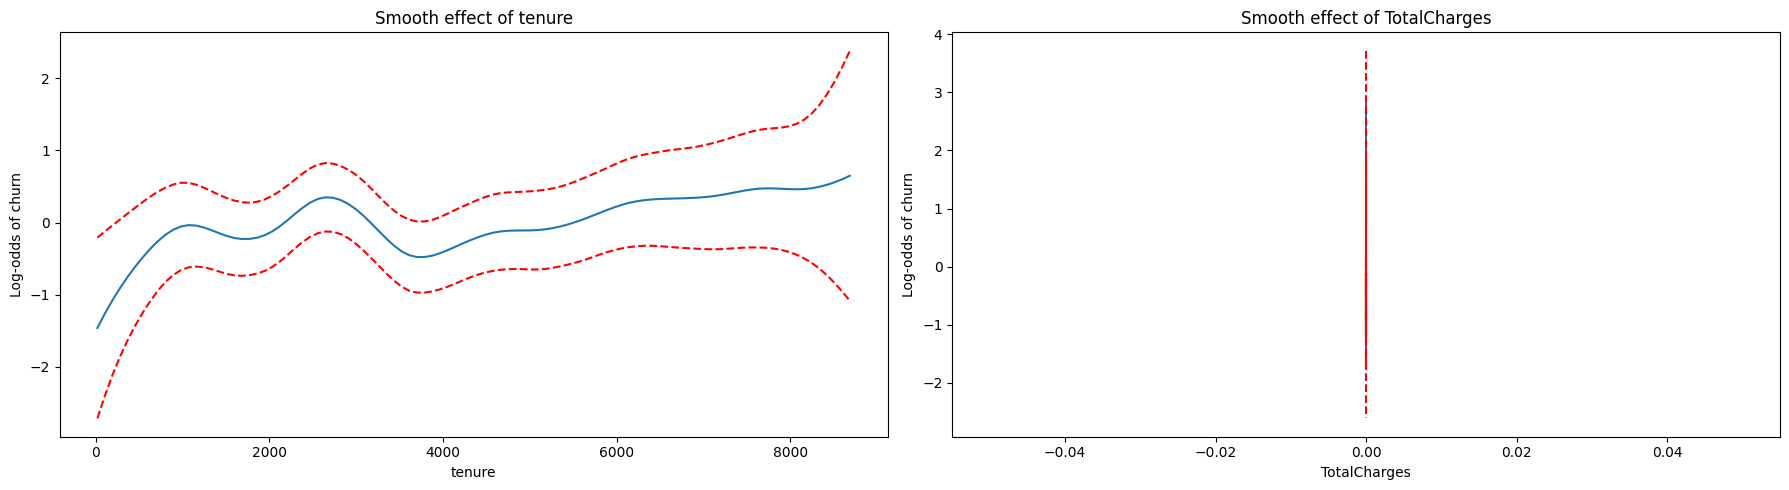

In [ ]:
# plotting the smooth terms for the continuous variables
numeric_cols = ['tenure', 'TotalCharges']

fig, axes = plt.subplots(1, 2, figsize=(18, 5)) 

for i, col in enumerate(numeric_cols):
    XX = gam.generate_X_grid(term=i)
    axes[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    axes[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    axes[i].set_title(f'Smooth effect of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Log-odds of churn')

plt.tight_layout()
plt.show()

> The GAM predicts customer churn with a pseudo R-squared of 0.30, indicating that the model explains about 30% of the variance in churn outcomes. This represents an improvement over the standard logistic regression, particularly for capturing non-linear effects.
>
> The model includes both continuous and categorical predictors. Continuous variables, `tenure` and `TotalCharges`, were modeled with smooth splines, while the remaining predictors were treated as factors.
>
> Key insights include:
> * `Tenure`: The smooth effect of tenure is non-linear (p < 0.001). Customers with very low or very high tenure show different risk patterns, confirming that the logit is not linear in tenure.
> * `TotalCharges`: The smooth effect is roughly linear (p ≈ 0.006), indicating that higher total charges slightly increase the odds of churn.
> * Categorical predictors: Most service and contract features are significant, including `InternetService_Fiber optic`, `Contract_One year` and `Contract_Two year`, `TechSupport_Yes`, `PaperlessBilling_Yes`, and several others, influencing the odds of churn similarly to logistic regression.
>
> Overall, the GAM provides a flexible approach that captures non-linear relationships in the data while maintaining interpretability for categorical predictors. This makes it a better fit than a standard logistic regression for modeling churn in this dataset.

### **Task 5: Model Comparison**

> #### **Linear Regression**
> * Performance: The linear regression model explains only 29.1% of the variance. Accuracy at a 0.5 cutoff is 79.6%, with MSE = 0.1434 and MAE = 0.3005. While these metrics seem reasonable, the model has fundamental limitations because churn is a binary outcome.
> * Interpretability: Coefficients are straightforward to interpret as changes in probability, e.g., each additional month of tenure reduces churn probability by 0.19%. Other key predictors like contract type, payment method, and InternetService also show expected signs.
> * Strengths: Easy to compute and interpret; provides rough probability estimates.
> * Weaknesses: Can predict probabilities outside [0,1], residuals show heteroskedasticity and non-normality, and VIF indicates severe multicollinearity. Linear regression models are not ideal for binary outcomes.
>
> #### **Logistic Regression**
> * Performance: Accuracy = 80.4%, ROC-AUC = 0.835. The model better handles the binary nature of churn, with probabilities constrained to [0,1]. Confusion matrix indicates a better prediction of non-churners, with some churn cases missed.
> * Interpretability: The model provides odd ratios, which are intuitive stakeholders. For example, fibre-optic customers are about twice as likely to churn, and two-year contracts reduce churn odds by about 78%.
> * Strengths: Interpretable, probability estimates are valid, captures linear effects well, fast to train and deploy.
> * Weaknesses: Assumes linearity in the logit for continuous variables and it cannot capture non-linear effects without transformation.
>
> #### **Generalized Additive Model (GAM)**
> * Performance: Pseudo R-squared = 0.302,slightl better than logistic regression. It captures non-linear effects, particularly for tenure, which shows a squiggly pattern in smooth plots. TotalCharges remains roughly linear.
> * Interpretability: Smooth effect plots allow visualization of non-linear relationships, while categorical effects remain clear. Significant terms highlight which factors influence churn most strongly.
> * Strengths: Captures complex patterns without manual transformations; interpretable via plots for continuous variables and coefficients for categorical variables.
> * Weaknesses: Slightly more complex to implement and explain. It is harder to translate smooth terms into odds ratios.
> 
> #### **Recommendation**
> * Operational use: Use logistic regression for routine churn prediction and reporting because of its interpretability, straightforward probability estimates, and odds ratios for decision-making.
> * Advanced analytics: Use GAM to explore and model non-linear effects (e.g., tenure) for strategic insights and targeted interventions.
> * Linear regression (LPM) can provide a rough estimate of churn probability but is not recommended for deployment due to its theoretical limitations and violation of regression assumptions.
